In [1]:
%load_ext autoreload
%autoreload 2

import evals2

from collections import namedtuple
import itertools as it
import numpy as np
import scipy.stats
import torch
from torch import nn, optim
import torch.nn.functional as F

SEED = 0
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = torch.device("cuda")

In [2]:
Task = namedtuple("Task", "spec features parts colors")

PARTS = ["stroke", "fill", "shadow"]
COLORS = ["red", "green", "blue", "black"]
SPECS1 = [(part, color) for part in PARTS for color in COLORS]
SPECS2 = [
    ((parts[0], color1), (parts[1], color2))
    for parts in it.combinations(PARTS, 2) 
    for color1 in COLORS 
    for color2 in COLORS
]
SPECS = SPECS2 # SPECS1 + SPECS2
N_FEATURES = len(PARTS) * len(COLORS)

TASKS = []
for spec in SPECS:
    features = np.zeros((len(PARTS), len(COLORS)))
    parts = []
    colors = []
    if isinstance(spec[0], str):
        spec_parts = [spec]
    else:
        spec_parts = spec
    for part, color in spec_parts:
        ipart = PARTS.index(part)
        icolor = COLORS.index(color)
        features[ipart, icolor] += 1
        parts.append(ipart)
        colors.append(icolor)
    features = torch.FloatTensor(features.ravel()).to(DEVICE)
    TASKS.append(Task(spec, features, parts, colors))

In [3]:
SOS = "<s>"
EOS = "</s>"
PAD = "<_>"

class Decoder(nn.Module):
    def __init__(self, vocab, start_sym, pad_sym):
        hid = N_HIDDEN
        super().__init__()
        self.vocab = vocab
        self.start_id = vocab[start_sym]
        self.pad_id = vocab[pad_sym]
        self.rnn = nn.GRU(input_size=len(vocab), hidden_size=hid, num_layers=1)
        self.predict = nn.Linear(hid, len(vocab))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, state, inp):
        rep, enc = self.rnn(inp, state)
        logits = self.predict(rep)
        return enc, logits

    def decode(self, init_state, max_len, sample=False):
        n_stack, n_batch, _ = init_state.shape
        out = [[self.start_id] for _ in range(n_batch)]
        tok_inp = [self.start_id for _ in range(n_batch)]
        state = init_state
        for i_step in range(max_len):
            hot_inp = np.zeros((1, n_batch, len(self.vocab)))
            for i, t in enumerate(tok_inp):
                hot_inp[0, i, t] = 1
            hot_inp = torch.FloatTensor(hot_inp).to(DEVICE)
            if init_state.is_cuda:
                hot_inp = hot_inp.cuda()
            new_state, label_logits = self(state, hot_inp)
            label_logits = label_logits.squeeze(0)
            label_logits[:, self.start_id] = -np.inf
            label_logits[:, self.pad_id] = -np.inf
            label_probs = self.softmax(label_logits).data.cpu().numpy()
            new_tok_inp = []
            for i, row in enumerate(label_probs):
                if sample:
                    tok = np.random.choice(row.size, p=row)
                else:
                    tok = row.argmax()
                new_tok_inp.append(tok)
                out[i].append(tok)
            state = new_state
            tok_inp = new_tok_inp
        return out


In [4]:
N_HIDDEN = 256
N_VOCAB = 16
MSG_LEN = 4

def make_seq(lol, max_len, n_vocab, batch_first=False):
    rr, cc = (len(lol), max_len) if batch_first else (max_len, len(lol))
    seq = np.zeros((rr, cc, n_vocab))
    for i, l in enumerate(lol):
        for j, tok in enumerate(l):
            r, c = (i, j) if batch_first else (j, i)
            seq[r, c, tok] = 1
    return torch.FloatTensor(seq).to(DEVICE)

def make_seq_tgt(lol, max_len, pad):
    tgt = np.ones((max_len, len(lol))) * pad
    for i, l in enumerate(lol):
        for j, tok in enumerate(l):
            tgt[j, i] = tok
    return torch.LongTensor(tgt).to(DEVICE)

class SeqPredictor(nn.Module):
    def __init__(self, vocab, n_features):
        super().__init__()
        self.vocab = vocab
        self.vocab[SOS] = len(self.vocab)
        self.vocab[PAD] = len(self.vocab)
        self.rev_vocab = {v: k for k, v in self.vocab.items()}
       
        self.rep = nn.Linear(n_features, N_HIDDEN)
        self.decoder = Decoder(self.vocab, SOS, PAD)
        self.loss = nn.CrossEntropyLoss(reduce=False, ignore_index = self.vocab[PAD])
        
        self.baseline = nn.Linear(n_features, 1)
    
    def sample(self, features, max_len, max=False):
        rep = self.rep(features).unsqueeze(0)
        dec = self.decoder.decode(rep, MSG_LEN, sample=not max)
        dec = [d[1:] for d in dec]
        return dec
    
    def forward(self, features, msgs, msgs_tgt):
        #print(msgs.argmax(dim=2))
        #print(msgs_tgt)
        #assert False
        
        rep = self.rep(features).unsqueeze(0)
        _, logits = self.decoder(rep, msgs)
        time, batch, vocab = logits.shape
        logits = logits.view(time * batch, vocab)
        msgs_tgt = msgs_tgt.view(time * batch)
        loss = self.loss(logits, msgs_tgt).view(time, batch)
        ent = -(F.softmax(logits, dim=1) * F.log_softmax(logits, dim=1)).sum(dim=1).view(time, batch)
        return loss.mean(dim=0), ent.mean(dim=0)
    
    def decode(self, seq):
        return "".join(self.rev_vocab[tok] for tok in seq)
            
class SpeakerModel(SeqPredictor):
    def __init__(self):
        speaker_vocab = {chr(ord('a') + i): i for i in range(N_VOCAB)}
        super().__init__(speaker_vocab, N_FEATURES)
        
    def sample(self, features, max=False):
        return super().sample(features, MSG_LEN, max)

class ListenerModel(nn.Module):
    def __init__(self):
        super().__init__()
        part_vocab = {part: i for i, part in enumerate(PARTS)}
        color_vocab = {color: i for i, color in enumerate(COLORS)}
        msg_size = MSG_LEN * (N_VOCAB+2)
        self.part_predictor = SeqPredictor(part_vocab, msg_size)
        self.color_predictor = SeqPredictor(color_vocab, msg_size)
        
    def sample(self, msgs, max=False):
        msg_feats = make_seq(msgs, MSG_LEN, N_VOCAB+2, batch_first=True)
        msg_feats = msg_feats.view(msg_feats.shape[0], -1)
        parts = self.part_predictor.sample(msg_feats, 2, max=max)
        colors = self.color_predictor.sample(msg_feats, 2, max=max)
        return parts, colors

In [5]:
N_TRAIN = len(TASKS) * 2 // 3
N_TEST = len(TASKS) - N_TRAIN
N_BATCH = 256

Rollout = namedtuple("Rollout", "tasks msgs parts colors rewards")

def rollout(speaker, listener, tasks, max=False):
    features = torch.stack([task.features for task in tasks])
    msgs = speaker.sample(features, max=max)
    parts, colors = listener.sample(msgs, max=max)
    parts = [p[:len(t.parts)] for p, t in zip(parts, tasks)]
    colors = [c[:len(t.colors)] for c, t in zip(colors, tasks)]
    
    rewards = []
    for part, color, task in zip(parts, colors, tasks):
        reward = 0.5 * (
            np.mean(np.asarray(part) == task.parts)
            + np.mean(np.asarray(color) == task.colors)
        )
        rewards.append(reward)
    
    return Rollout(tasks, msgs, parts, colors, rewards)

def make_loss(targets, features, rewards, max_len, n_vocab, decoder, use_baseline=True):
    pre_targets = [[decoder.vocab[SOS]] + s[:-1] for s in targets]
    seq = make_seq(pre_targets, max_len, n_vocab)
    seq_tgt = make_seq_tgt(targets, max_len, decoder.vocab[PAD])
    nll, ent = decoder(features, seq, seq_tgt)
    
    value = decoder.baseline(features).squeeze(1)
    baseline = value.detach() if use_baseline else 0
    
    surrogate = -nll * (rewards - baseline) + 0.01 * ent
    return -surrogate.mean() + F.mse_loss(value, rewards)

def step(opt, speaker, listener, result):
    rewards = torch.FloatTensor(result.rewards).to(DEVICE)
    speaker_loss = make_loss(
        result.msgs,
        torch.stack([t.features for t in result.tasks]),
        rewards,
        MSG_LEN,
        N_VOCAB+2,
        speaker,
    )
    
    msg_feats = make_seq(result.msgs, MSG_LEN, N_VOCAB+2, batch_first=True)
    msg_feats = msg_feats.view(msg_feats.shape[0], -1)
    part_loss = make_loss(
        [t.parts for t in result.tasks], #result.parts,
        msg_feats,
        torch.ones(len(result.tasks)).to(DEVICE), #rewards,
        2,
        len(PARTS)+2,
        listener.part_predictor,
        use_baseline=False
    )
    color_loss = make_loss(
        [t.colors for t in result.tasks], #result.colors,
        msg_feats,
        torch.ones(len(result.tasks)).to(DEVICE), #rewards,
        2,
        len(COLORS)+2,
        listener.color_predictor,
        use_baseline=False
    )
    
    loss = speaker_loss + part_loss + color_loss
    opt.zero_grad()
    loss.backward()
    opt.step()
    
def train(tasks):
    speaker = SpeakerModel().to(DEVICE)
    listener = ListenerModel().to(DEVICE)
    params = it.chain(speaker.parameters(), listener.parameters())
    opt = optim.RMSprop(params, lr=0.003)
    for i in range(200):
        batch_tasks = [
            train_tasks[np.random.randint(N_TRAIN)]
            for _ in range(N_BATCH)
        ]
        result = rollout(speaker, listener, batch_tasks)
        step(opt, speaker, listener, result)
    return speaker, listener

In [6]:
class Compose(nn.Module):
    def __init__(self):
        super().__init__()
        self.lproj = nn.Linear(MSG_LEN, MSG_LEN)
        self.rproj = nn.Linear(MSG_LEN, MSG_LEN)
        
    def forward(self, x, y):
        x = x.view(1, N_VOCAB+2, MSG_LEN)
        y = y.view(1, N_VOCAB+2, MSG_LEN)
        xproj = self.lproj(x)
        yproj = self.rproj(y)
        return (xproj + yproj).view(1, (N_VOCAB+2) * MSG_LEN)
                   
def lift(msg):
    data = np.zeros((N_VOCAB+2, MSG_LEN))
    for i, tok in enumerate(msg):
        data[tok, i] = 1
    return data.ravel()

COMP_FN = Compose()
ERR_FN = evals2.L1Dist()

def evaluate(speaker, listener, tasks):
    for task in tasks:
        result = rollout(speaker, listener, tasks, max=True)
        return np.mean(result.rewards)
    
def pp(t):
    if isinstance(t, tuple):
        return "(%s)" % " ".join(pp(tt) for tt in t)
    return str(t)
    
def evaluate_language(speaker, listener, train_tasks, test_tasks):
    result = rollout(speaker, listener, train_tasks + test_tasks, max=True)
    test_specs = set([t.spec for t in test_tasks])
    data = []
    for i in range(len(result.tasks)):
        data.append((result.tasks[i].spec, result.msgs[i], result.rewards[i]))
    specs, msgs, rewards = zip(*data)
    msgs = [lift(m) for m in msgs]
    comp = evals2.evaluate(msgs, specs, COMP_FN, ERR_FN, quiet=True, steps=1000)
    return np.mean(comp), data

In [7]:
header =   "      %10s %10s %10s %10s" % ("train", "test", "diff", "comp")
template = "[%3d] %10.2f %10.2f %10.2f %10.2f %10s"

languages = []
datapoints = []
print(header)
for i in range(100):
    tasks = list(TASKS)
    np.random.shuffle(tasks)
    train_tasks, test_tasks = tasks[:N_TRAIN], tasks[N_TRAIN:]
    
    speaker, listener = train(train_tasks)
    train_acc = evaluate(speaker, listener, train_tasks)
    test_acc = evaluate(speaker, listener, test_tasks)
    comp, lang = evaluate_language(speaker, listener, train_tasks, test_tasks)
    datapoints.append((train_acc, test_acc, train_acc - test_acc, comp))
    languages.append(lang)
    sig = scipy.stats.pearsonr([d[2] for d in datapoints], [d[3] for d in datapoints])
    print(template % (i, train_acc, test_acc, train_acc - test_acc, comp, sig))


           train       test       diff       comp


/home/jda/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


[  0]       0.73       0.55       0.19       4.07 (nan, nan)
[  1]       0.51       0.55      -0.04       1.70 (1.0, 0.0)
[  2]       0.58       0.59      -0.02       3.92 (0.6226296508385887, 0.5721286573976438)
[  3]       0.62       0.38       0.24       3.77 (0.6013725880083152, 0.39862741199168483)
[  4]       0.48       0.41       0.07       3.07 (0.6051896663495953, 0.2794837466591908)
[  5]       0.65       0.42       0.23       4.05 (0.6585753654893783, 0.1549561034186389)
[  6]       0.67       0.52       0.16       4.17 (0.6645060332043701, 0.10346425671199311)
[  7]       0.99       0.67       0.32       4.30 (0.6976376792210263, 0.054383302993083985)
[  8]       0.54       0.36       0.18       3.18 (0.6642097865914263, 0.051027149220265994)
[  9]       0.61       0.38       0.23       3.59 (0.6466601475568874, 0.04332154657712421)
[ 10]       0.44       0.23       0.20       0.94 (0.34174210994899196, 0.30365745234582314)
[ 11]       0.59       0.31       0.28       3.58 

[ 88]       0.53       0.44       0.09       1.85 (0.46483106168984556, 4.451785033669294e-06)
[ 89]       0.41       0.38       0.03       1.74 (0.4697914226793617, 2.9910009037455735e-06)
[ 90]       0.60       0.41       0.20       3.84 (0.4731544138160895, 2.176445143663783e-06)
[ 91]       0.51       0.41       0.10       1.16 (0.47388409800582637, 1.829920097063896e-06)
[ 92]       0.70       0.52       0.18       3.57 (0.47572150387070683, 1.4418222998947933e-06)
[ 93]       0.39       0.34       0.05       0.45 (0.48383460867663586, 7.801621104008926e-07)
[ 94]       0.56       0.45       0.11       2.86 (0.48311670793724404, 7.095198782803463e-07)
[ 95]       0.98       0.64       0.34       4.23 (0.49568618659783925, 2.8217407955226693e-07)
[ 96]       0.53       0.28       0.25       2.44 (0.4892245408060497, 3.6789561928069607e-07)
[ 97]       0.63       0.50       0.13       3.97 (0.4858938774342077, 3.942276326839545e-07)
[ 98]       0.49       0.52      -0.02       1.29 

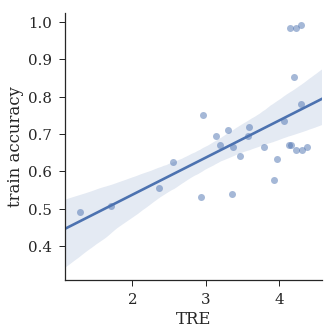

(0.6057255241343904, 0.0006359153358373467)


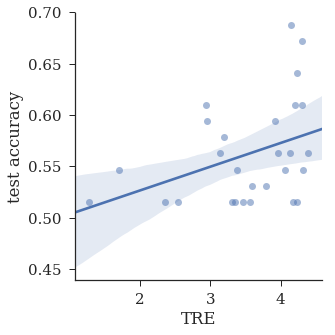

(0.38113695084689336, 0.045382127083705474)


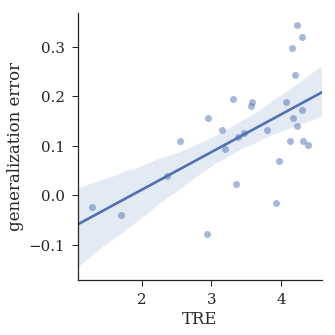

(0.6003785394866578, 0.000730923516445476)


In [20]:
import seaborn as sns
from matplotlib import pyplot as plt
from pandas import DataFrame

sns.set(font_scale=1.5)
sns.set_style("ticks", {'font.family': 'serif'})
plt.tight_layout()

points = datapoints
points = [d for d in datapoints if d[1] > 0.5]

train_acc, test_acc, diff, comp = zip(*points)
data = DataFrame({'train_acc': train_acc, 'test_acc': test_acc, 'diff': diff, 'comp': comp})

def plot(y, fname, ylabel):
    sns.lmplot(x='comp', y=y, data=data, fit_reg=True, scatter_kws={'alpha': 0.5})
    plt.xlabel('TRE')
    plt.ylabel(ylabel)
    plt.savefig('comm_shapes_%s.pdf' % fname, format='pdf')
    plt.show()

plot('train_acc', 'train', 'train accuracy')
print(scipy.stats.pearsonr(comp, train_acc))

plot('test_acc', 'test', 'test accuracy')
print(scipy.stats.pearsonr(comp, test_acc))

plot('diff', 'gen', 'generalization error')
print(scipy.stats.pearsonr(comp, diff))

#sns.lmplot(x='train_acc', y='diff')

In [23]:
def vis(lang):
    for spec, msg, rew in sorted(lang, key=lambda x: str(x[0])):
        print("%55s %-33s %6s %.2f" % (
            "",
            pp(spec), #+ ("*" if spec in test_specs else " "),
            speaker.decode(msg),
            rew
        ))
        
print(datapoints[63])
vis(languages[63])
print()
print(datapoints[17])
vis(languages[17])

(0.78125, 0.609375, 0.171875, 4.303449834386508)
                                                        ((fill black) (shadow black))       jjjj 0.25
                                                        ((fill black) (shadow blue))        oddd 1.00
                                                        ((fill black) (shadow green))       oooo 0.75
                                                        ((fill black) (shadow red))         oddd 0.75
                                                        ((fill blue) (shadow black))        jjjj 0.50
                                                        ((fill blue) (shadow blue))         pppp 0.75
                                                        ((fill blue) (shadow green))        pppp 1.00
                                                        ((fill blue) (shadow red))          pppp 0.75
                                                        ((fill green) (shadow black))       jjjj 0.25
                                 